---
title: Raster Data
subtitle: DSE EcoTech Series (2024)
author:
    name: Brookie Guzder-Williams
    affiliations: 
        - The Eric and Wendy Schmidt Center for Data Science & Environment
        - University of California Berkeley
    orcid: 0000-0001-6855-8260
    email: bguzder-williams@berkeley.edu
date: 2024-10-23
---

license: CC-BY-4.0


---

### IMPORTS

In [1]:
from typing import Any, Union
import sys
from  pathlib import Path
from pprint import pprint
import rich.pretty as rp
import matplotlib.pyplot as plt
from io import BytesIO
from urllib.request import urlopen
import numpy as np
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import localtileserver
import leafmap


---

### CONSTANTS

In [2]:
DATA_FOLDER = '../data/raster'
S2_ZARR_PATH = f'{DATA_FOLDER}/sentinel_2.zarr'

In [3]:
PATHS = [p for p in Path(DATA_FOLDER).glob(f'*.tif')]


---

## READING DATA

### RASTERIO

[rasterio](https://rasterio.readthedocs.io/en/stable/) is a great package for working with GIS data. Here we'll simply be using it to read in raster data. \
The `read_rio(...)` method below returns a numpy array (`arr`) containing the pixel-values and a dictionary \
containing geospatial and other meta-data (`profile`)

In [229]:
print('GEOTIFFS:')
for i, p in enumerate(PATHS):
    print(i, p.name)

GEOTIFFS:
0 tahoe-dem.tif
1 tahoe-mean-s2-20210101_20210301.tif


In [249]:
def visualize_arrays(s2_arr: np.ndarray, dem_arr: np.ndarray) -> None:
    """ visualize sentinel-2 and dem data
    1. compute an S2 RGB array uint8 array for visualization 
    2. select the elevation band of the DEM array
    """
    s2_rgb =(s2_arr[[4,3,2]].swapaxes(0,1).swapaxes(1,2) / 10000)
    s2_rgb = ((s2_rgb - 0.0) * 255 / 0.5).clip(0,255).round().astype(int)
    elevation = dem_arr[0]
    s2_rgb.shape, elevation.shape
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    plt.suptitle("Sentinel-2 and Elevation data from Tahoe Region", fontsize=24, color='#333', fontweight='light')
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title('DEM', fontsize=13, color='#666')
    axs[0].imshow(elevation, cmap="hot")
    axs[1].set_title('S2 (mean 20210101-20210301)', fontsize=13, color='#666')
    axs[1].imshow(s2_rgb)
    plt.show()

def print_raster_info(name, arr: np.ndarray, profile: dict[str, Any]) -> None:
    """ prints out information about the raster """
    print('-' * 25)
    print(f'{name}')
    print('-' * 25)
    print('shape:', arr.shape)
    print('mean:', np.nanmean(arr))
    print('max:', np.nanmax(arr))
    print('min:', np.nanmin(arr))
    print('-' * 10)
    for k, v in profile.items():
        print(f'{k}:', v)

def line():
    print('-' * 75)

---------------------------------------------------------------------------
Sentinel-2: (26, 3756, 4118)


{
│   'driver': 'GTiff',
│   'dtype': 'float64',
│   'nodata': None,
│   'width': 4118,
│   'height': 3756,
│   'count': 26,
│   'crs': CRS.from_epsg(4326),
│   'transform': Affine(0.00026949458523585647, 0.0, -120.84568393312182,
│      0.0, -0.00026949458523585647, 39.653702766189156),
│   'blockxsize': 256,
│   'blockysize': 256,
│   'tiled': True,
│   'compress': 'lzw',
│   'interleave': 'pixel'
}

---------------------------------------------------------------------------


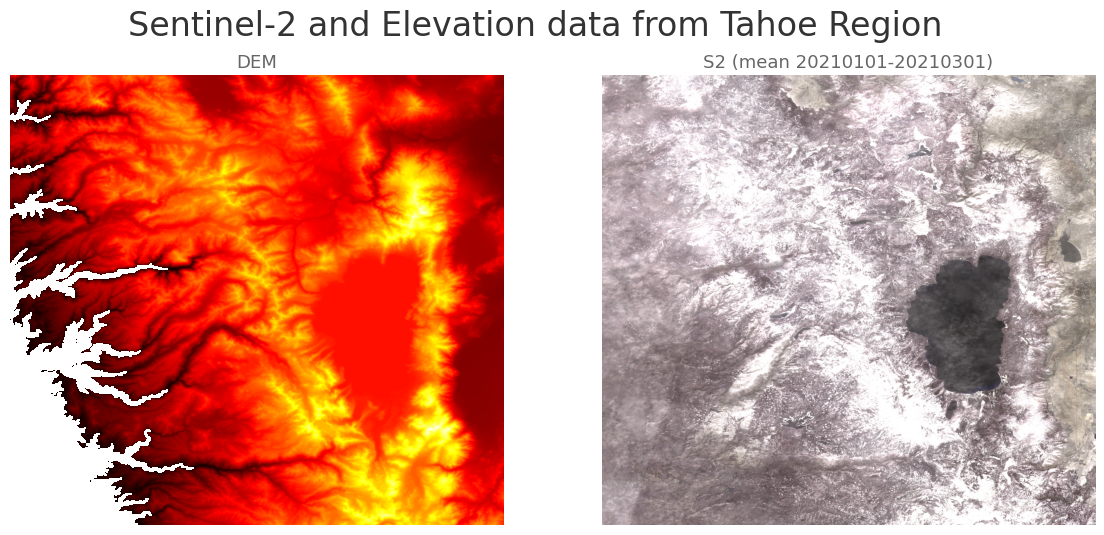

In [270]:
#| label: nb:raster:readrio
def read_rio(path: str) -> tuple[np.ndarray, dict[str, Any]]:
    """ read a geotiff using rasterio """
    with rio.open(path,'r') as src:
        profile = src.profile
        arr = src.read()
    return arr, profile

dem_arr, dem_profile = read_rio(PATHS[0])
s2_arr, s2_profile = read_rio(PATHS[1])
line()
print('Sentinel-2:', s2_arr.shape)
rp.pprint(s2_profile)
line()
visualize_arrays(s2_arr, dem_arr)

One can also use GDAL from the command line to see the geospatial data

In [70]:
!gdalinfo ../data/raster/tahoe-dem.tif

Driver: GTiff/GeoTIFF
Files: ../data/raster/tahoe-dem.tif
Size is 4118, 3756
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        MEMBER["World Geodetic System 1984 (G2296)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDE

### VISUALIZE THE DATA

We can now visualize these images.  First I'll compute an RGB array uint8 array, and select the elevation band from the dem\
Note I'm swapping axes in order to use matplotlib for plotting

## XARRAY

### RIOXARRY

[rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html) allows one to read the tif directly into an xarray format\
NOTE: the reading of the data happens lazily when you call `ds.data`

In [259]:
#| label: nb:raster:s2_da
da = rxr.open_rasterio(PATHS[1])
print('array equality:', np.array_equal(da.data, s2_arr, equal_nan=True))
da

array equality: True


<xarray.DataArray (band: 26, y: 3756, x: 4118)> Size: 3GB
array([[[4440.833333, 4574.434783, ..., 2939.885417, 2939.885417],
        [4373.208333, 4245.291667, ..., 2973.09375 , 2973.09375 ],
        ...,
        [3703.      , 3703.      , ..., 2665.916667, 2580.958333],
        [3703.      , 3703.      , ..., 2539.416667, 2541.375   ]],

       [[4283.541667, 4328.833333, ..., 2923.75    , 3007.864583],
        [4429.708333, 4070.625   , ..., 3190.71875 , 3259.989583],
        ...,
        [3792.916667, 3786.666667, ..., 2850.541667, 2573.666667],
        [3700.      , 3719.75    , ..., 2504.375   , 2566.75    ]],

       ...,

       [[        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan],
        ...,
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]],

       [[        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan],
        ...,
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]]])
Coordinates:
  * band         (band) int64 208B 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26
  * x            (x) float64 33kB -120.8 -120.8 -120.8 ... -119.7 -119.7 -119.7
  * y            (y) float64 30kB 39.65 39.65 39.65 39.65 ... 38.64 38.64 38.64
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '...

There a few advantages using XARRAY:

- we now have access to the lat, lon values `ds.x,y`
- we also have access to the band-names `ds.long_name` whose order corresponds with the returned numpy array

When working with xarray data the zarr data-type is a good option.  We'll first convert the data-array to a dataset and then save it

In [260]:
ds = da.to_dataset(name='s2')
ds

<xarray.Dataset> Size: 3GB
Dimensions:      (band: 26, x: 4118, y: 3756)
Coordinates:
  * band         (band) int64 208B 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26
  * x            (x) float64 33kB -120.8 -120.8 -120.8 ... -119.7 -119.7 -119.7
  * y            (y) float64 30kB 39.65 39.65 39.65 39.65 ... 38.64 38.64 38.64
    spatial_ref  int64 8B 0
Data variables:
    s2           (band, y, x) float64 3GB 4.441e+03 4.574e+03 ... nan nan

perhaps it would be nicer to have the data organized by band names

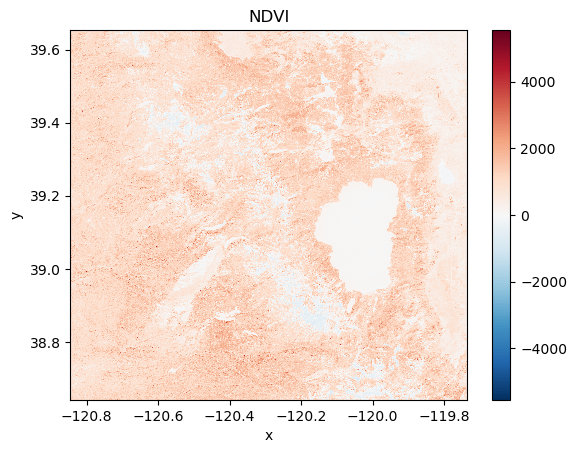

<xarray.Dataset> Size: 3GB
Dimensions:              (y: 3756, x: 4118)
Coordinates:
  * x                    (x) float64 33kB -120.8 -120.8 -120.8 ... -119.7 -119.7
  * y                    (y) float64 30kB 39.65 39.65 39.65 ... 38.64 38.64
Data variables: (12/26)
    B1                   (y, x) float64 124MB 4.441e+03 4.574e+03 ... 2.541e+03
    B2                   (y, x) float64 124MB 4.284e+03 4.329e+03 ... 2.567e+03
    B3                   (y, x) float64 124MB 4.242e+03 4.259e+03 ... 2.694e+03
    B4                   (y, x) float64 124MB 4.133e+03 4.163e+03 ... 2.808e+03
    B5                   (y, x) float64 124MB 4.543e+03 4.409e+03 ... 3.042e+03
    B6                   (y, x) float64 124MB 4.922e+03 4.761e+03 ... 3.337e+03
    ...                   ...
    QA10                 (y, x) float64 124MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    QA20                 (y, x) float64 124MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    QA60                 (y, x) float64 124MB 426.7 426.7 426.7 ... 597.3 597.3
    MSK_CLASSI_OPAQUE    (y, x) float64 124MB nan nan nan nan ... nan nan nan
    MSK_CLASSI_CIRRUS    (y, x) float64 124MB nan nan nan nan ... nan nan nan
    MSK_CLASSI_SNOW_ICE  (y, x) float64 124MB nan nan nan nan ... nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '...

In [264]:
#| label: nb:raster:s2_ds
def bandify_data_array(da: xr.DataArray, bands: Union[list[str], str]='long_name') -> xr.Dataset:
    """ transform data-array to dataset with band-valued data_vars """
    if isinstance(bands, str):
        bands = list(da.attrs[bands])
    return xr.Dataset(
        data_vars={b: (['y', 'x'], da.data[i]) for i, b in enumerate(bands)},
        coords=dict(
            x=("x", da.x.data),
            y=("y", da.y.data)
        ),
        attrs=da.attrs)

ds = bandify_data_array(da)
(ds.B8-ds.B4).plot()
plt.title('NDVI')
plt.show()
ds

In [252]:
if Path(S2_ZARR_PATH).exists():
    print(f'[INFO]: zarr-output exists: to re-run first delete zarr-directory ({S2_ZARR_PATH})')
else:
    ds.to_zarr(S2_ZARR_PATH)

[INFO]: zarr-output exists: to re-run first delete zarr-directory (../data/raster/sentinel_2.zarr)


## COG

In [274]:
#| label: nb:raster:riocogeo-s2
!rio cogeo create ../data/raster/tahoe-mean-s2-20210101_20210301.tif ../data/raster/cogs/tahoe-mean-s2-20210101_20210301.tif

Reading input: /Users/brookieguzder-williams/code/dse/map_something/repo/data/raster/tahoe-mean-s2-20210101_20210301.tif
  [####################################]  100%          
Adding overviews...
Updating dataset tags...
Writing output to: ../data/raster/cogs/tahoe-mean-s2-20210101_20210301.tif


In [275]:
!rio cogeo create ../data/raster/tahoe-dem.tif ../data/raster/cogs/tahoe-dem.tif

Reading input: /Users/brookieguzder-williams/code/dse/map_something/repo/data/raster/tahoe-dem.tif
  [####################################]  100%
Adding overviews...
Updating dataset tags...
Writing output to: ../data/raster/cogs/tahoe-dem.tif


In [276]:
!gdalinfo ../data/raster/cogs/tahoe-mean-s2-20210101_20210301.tif

Driver: GTiff/GeoTIFF
Files: ../data/raster/cogs/tahoe-mean-s2-20210101_20210301.tif
Size is 4118, 3756
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        MEMBER["World Geodetic System 1984 (G2296)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (L

In [277]:
cog, cog_profile = read_rio('../data/raster/cogs/tahoe-mean-s2-20210101_20210301.tif')
print(cog.shape)
rp.pprint(cog_profile)

(26, 3756, 4118)


{
│   'driver': 'GTiff',
│   'dtype': 'float64',
│   'nodata': None,
│   'width': 4118,
│   'height': 3756,
│   'count': 26,
│   'crs': CRS.from_epsg(4326),
│   'transform': Affine(0.00026949458523585647, 0.0, -120.84568393312182,
│      0.0, -0.00026949458523585647, 39.653702766189156),
│   'blockxsize': 512,
│   'blockysize': 512,
│   'tiled': True,
│   'compress': 'deflate',
│   'interleave': 'pixel'
}

In [278]:
rp.pprint(s2_profile)

{
│   'driver': 'GTiff',
│   'dtype': 'float64',
│   'nodata': None,
│   'width': 4118,
│   'height': 3756,
│   'count': 26,
│   'crs': CRS.from_epsg(4326),
│   'transform': Affine(0.00026949458523585647, 0.0, -120.84568393312182,
│      0.0, -0.00026949458523585647, 39.653702766189156),
│   'blockxsize': 256,
│   'blockysize': 256,
│   'tiled': True,
│   'compress': 'lzw',
│   'interleave': 'pixel'
}